In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.train import BnFreeze
import os
from radam import *
from csvlogger import *
from mish import *
import cv2
from collections import defaultdict
from albumentations import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.60'

In [2]:
sz = 128
bs = 8
nfolds = 4
fold = 0
SEED = 43
N = 96
TRAIN = 'data/train_adv_128x128/'
LABELS = 'data/train_d2.csv'
LABELS_D2 = 'data/d2.csv'
OUT = 'k_128rnew'
EXCLUDE = 'data/PANDA_Suspicious_Slides.csv'
OUT = 'k_128rnew1'
NUM_WORKERS = 24

os.makedirs(OUT, exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

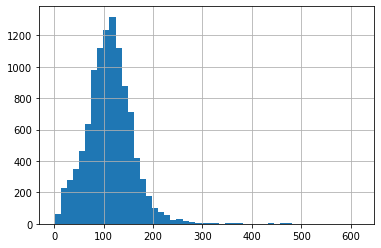

In [3]:
#the histogram of the number of tiles per image
files = sorted(os.listdir(TRAIN))
fdict = dict()
for f in files:
    k,v = f[:-4].split('_')
    if k not in fdict: fdict[k] = 1
    else: fdict[k] += 1
        
fdict = pd.DataFrame(fdict.items())
fdict.columns = ['image_id','ntiles']
fdict = fdict.set_index('image_id')
fdict.ntiles.hist(bins=50);

In [5]:
df = pd.read_csv(LABELS).set_index('image_id')
df = df.join(pd.read_csv(LABELS_D2).set_index('image_id'))
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df.gleason_score = df.gleason_score.replace('negative','0+0')
df = df.loc[files]
df_e = df.loc[df.isup_grade != df.isup_grade0].copy().reset_index()
df = df.loc[df.isup_grade == df.isup_grade0]
df = df.reset_index()
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df = pd.concat((df,df_e)).fillna(-1)
df.split = df.split.astype(np.int)
Ng, Ns = df.nunique()[2], df.nunique()[3]
score_map = {s:i for i,s in enumerate(df.gleason_score.unique())}
df['score'] = df.gleason_score.map(score_map)
df['provider'] = df.data_provider == 'karolinska'
df = df.loc[(df.data_provider == 'karolinska') |
            ((df.data_provider == 'radboud') & (np.abs(df.isup_grade - df.isup_grade_d2 + 0.5) < 0.75))]
df = df.set_index('image_id')
exclude = set(pd.read_csv(EXCLUDE).image_id)
df = df.loc[~df.index.isin(exclude)]
df = df.reset_index()

df = pd.read_csv('data/train.csv').set_index('image_id').join(df.set_index('image_id')[['split','isup_grade0']])\
    .fillna(-1)
df.split = df.split.astype(np.int)
df = df.reset_index()
df['provider'] = df.data_provider == 'karolinska'
df.gleason_score = df.gleason_score.replace('negative','0+0')
df['score'] = df.gleason_score.map(score_map)
df['isup_grade0'] = df['isup_grade']
df['m'] = df.isup_grade
df.head()

,image_id,data_provider,isup_grade,gleason_score,split,isup_grade0,provider,score,m
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1,0,True,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0,True,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,-1,4,False,1,4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1,4,True,1,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1,0,True,0,0


In [6]:
mean = np.array([1.0-0.85506157, 1.0-0.7035249, 1.0-0.80203127])
std = np.array([0.40011922, 0.52504386, 0.42675745])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class PANDADataset(Dataset):
    def __init__(self, df, fold=fold, train=True, tfms=None, total=False):
        self.df = df.copy()
        if not total: self.df = self.df.loc[self.df.split != -1]
        else: self.df.loc[self.df.split == -1, 'split'] = fold
        self.df = self.df.loc[self.df.split != fold] if train else self.df.loc[self.df.split == fold]
        self.df = self.df.reset_index(drop=True)
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        labels = self.df.iloc[idx][['isup_grade','score','provider','m']].astype(np.long).values
        provider = self.df.iloc[idx].data_provider
        
        idx = self.df.iloc[idx].image_id
        imgs = []
        ntiles = fdict.loc[idx].values[0]
        n = N if self.train else 2*N
        if self.train: ids = random.choices(range(ntiles),k=n)
        else: ids = range(min(n,ntiles))
        
        for i in ids:
            img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,idx+'_'+str(i)+'.png')), cv2.COLOR_BGR2RGB)
            img = 255 - img
            if self.tfms is not None:
                augmented = self.tfms(image=img)
                img = augmented['image']
            imgs.append(img)
        if len(ids) < n: 
            for i in range(n - len(ids)): imgs.append(np.zeros((sz,sz,3),np.uint8))
        
        imgs = [img2tensor((img/255.0 - mean)/std,np.float32) for img in imgs]
        return (torch.stack(imgs,0),max(len(ids),1)), labels

In [7]:
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.3, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_CONSTANT),
        OneOf([
            MotionBlur(blur_limit=3, p=0.1),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

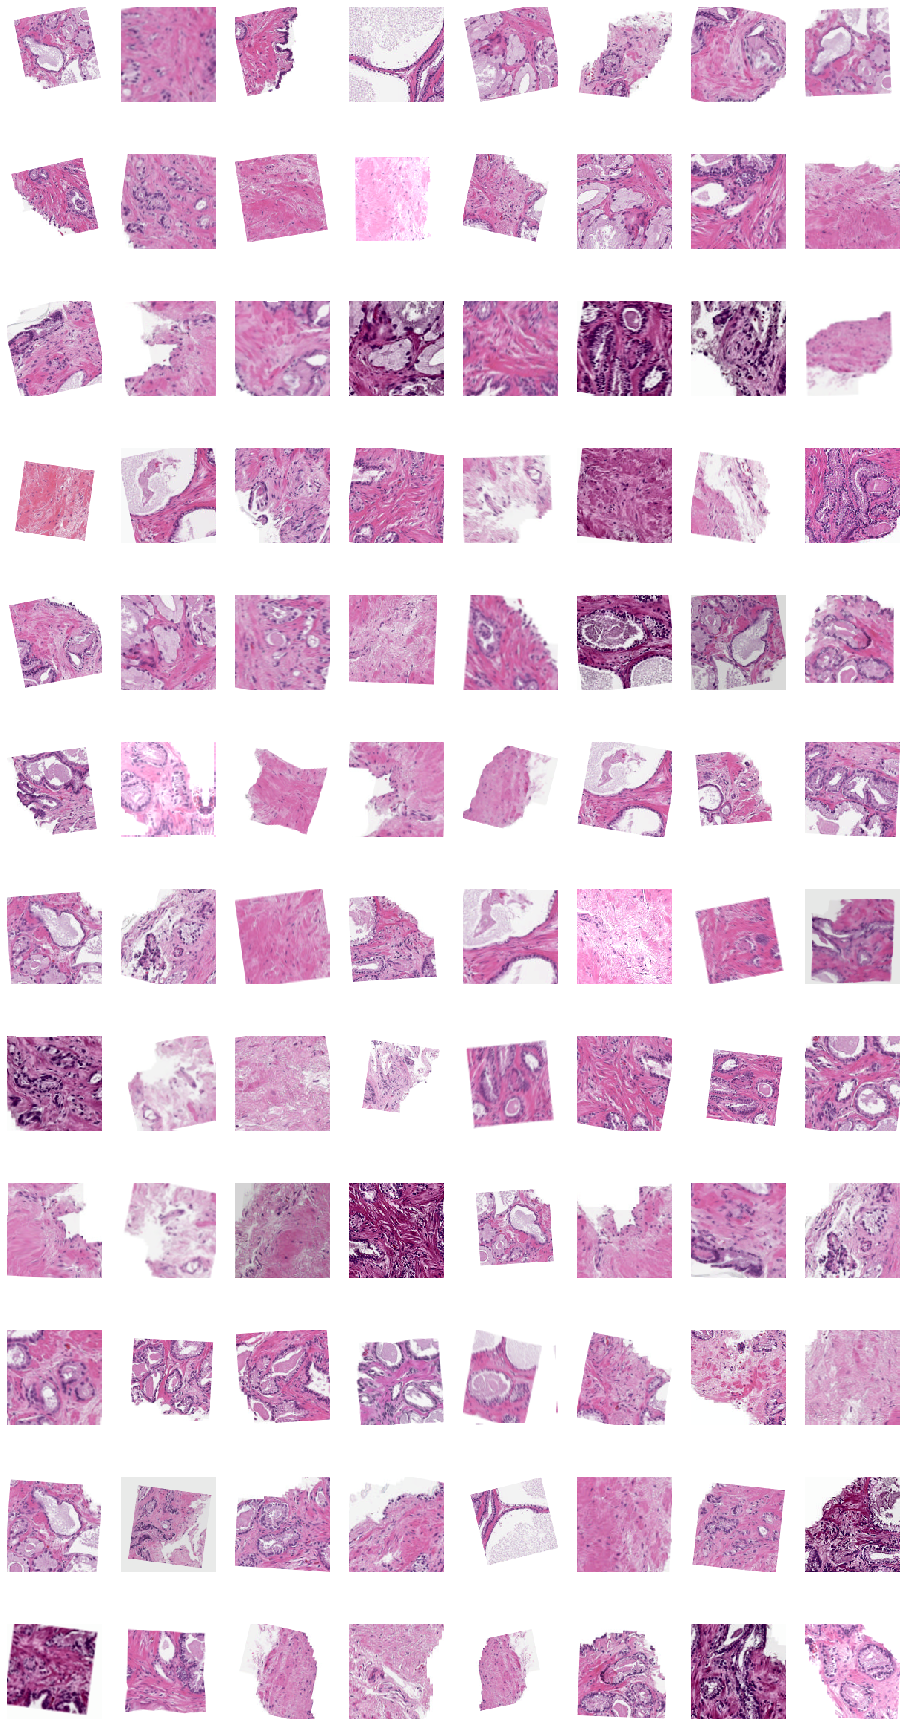

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

ds = PANDADataset(df, fold=fold, train=True, tfms=get_aug())
x,y = ds[5]
x = x[0]
t = 255 - ((x.permute(0,2,3,1)*std + mean)*255.0).byte()
plt.figure(figsize=(16,32))
for i in range(len(t)):
    plt.subplot(N//8,8,i+1)
    plt.imshow(t[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

In [9]:
def AdaptiveConcatMaskPool2d(x,m,output_size=1):
    result = []
    for xi,mi in zip(x,m):
        xi = xi[:mi].unsqueeze(0)
        shape = xi.shape
        xi = xi.permute(0,2,1,3,4).contiguous().view(-1,shape[2],shape[3]*mi,shape[4])
        result.append(torch.cat([F.adaptive_max_pool2d(xi,output_size),
                                 F.adaptive_avg_pool2d(xi,output_size)],1))
    return torch.cat(result, 0)

class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=Ns, pre=True,ps=0.5):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        nc = list(m.children())[-1].in_features
        self.enc = nn.Sequential(*list(m.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),
                                  nn.Linear(2*nc,512),Mish(),nn.GroupNorm(32,512),
                                  nn.Dropout(ps),nn.Linear(512,n+1))
        
    def forward(self, x, m):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        
        shape = x.shape
        x = AdaptiveConcatMaskPool2d(x.view(-1,n,shape[1],shape[2],shape[3]),m)
        x = self.head[1:](x)
        return x[:,:1],x[:,1:]

In [10]:
y_shift = df.isup_grade.mean()
def Kloss(x, target):
    x = Ng*torch.sigmoid(x.float()).view(-1) - 0.5
    target = target.float()
    return 1.0 - (2.0*((x-y_shift)*(target-y_shift)).sum() - 1e-3)/\
        (((x-y_shift)**2).sum() + ((target-y_shift)**2).sum() + 1e-3)

def Combine_loss(x, target):
    loss_c = Kloss(x[0].float(),target[:,0])
    loss_caux = F.cross_entropy(x[1].float(),target[:,1])
    return loss_c + 0.08*loss_caux

In [11]:
class DConfusionMatrix(Callback):
    def __init__(self, provider=None, **kwargs):
        self.provider=provider
        super().__init__(**kwargs)
    
    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        if self.provider is None:
            last_output = last_output[0]
            last_target = last_target[:,0]
        else:
            idxs = last_target[:,2] == self.provider
            last_output = last_output[0][idxs]
            last_target = last_target[:,0][idxs]
            if len(last_output)  == 0: return
        preds = torch.clamp((Ng*torch.sigmoid(last_output.float())).long().view(-1).cpu(),0,5)
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = Ng
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm

class DKappaScore(DConfusionMatrix):
    def __init__(self, weights:Optional[str]=None, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights  # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)
    
class kappa_k(DKappaScore):
    def __init__(self):
        super().__init__(weights='quadratic',provider=1)
        
class kappa_r(DKappaScore):
    def __init__(self):
        super().__init__(weights='quadratic',provider=0)

In [12]:
fname = 'RNXT50_128krnew1_2'
pred,pred_y = [],[]
for fold in range(nfolds):
    ds_t = PANDADataset(df, fold=fold, train=True, tfms=get_aug())
    ds_v = PANDADataset(df, fold=fold, train=False)
    data = DataBunch.create(ds_t,ds_v,bs=bs,num_workers=NUM_WORKERS)
    model = Model()
    model.load_state_dict(torch.load(os.path.join('d1',f'RNXT50_s43_{fold}.pth')))
    model = nn.DataParallel(model)
    learn = Learner(data, model, loss_func=Combine_loss, opt_func=Over9000, 
                metrics=[DKappaScore(weights='quadratic'),kappa_k(),kappa_r()]).to_fp16()
    logger = CSVLogger(learn,os.path.join(OUT,f'log_{fname}_{fold}'))
    learn.clip_grad = 1.0
    learn.split([model.module.head])
    learn.unfreeze()

    learn.fit_one_cycle(48, max_lr=slice(1e-4,1e-3), div_factor=50, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'{fname}_{fold}',monitor='d_kappa_score',every='epoch'),
                   SaveModelCallback(learn,name=f'model',monitor='d_kappa_score')])
    torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(x[0].cuda().half(),x[1].cuda())
            pred.append(p[0].float().view(-1).cpu())
            pred_y.append(y[:,0].cpu())
            
p = torch.clamp((6.0*torch.sigmoid(torch.cat(pred))).long(),0,5)
t = torch.cat(pred_y)
print(cohen_kappa_score(p,t,weights='quadratic'))
print(confusion_matrix(t,p))

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.322853,0.285811,0.800128,0.705712,0.841517,08:00
1,0.297047,0.213059,0.863965,0.783746,0.902405,08:00
2,0.276121,0.192445,0.881724,0.819723,0.913222,07:55
3,0.236426,0.150188,0.914965,0.878377,0.940511,07:57
4,0.215774,0.223758,0.856025,0.835295,0.849333,07:56
5,0.206443,0.151434,0.914446,0.878799,0.931329,07:56
6,0.204027,0.137737,0.922245,0.892016,0.936415,07:57
7,0.210002,0.131125,0.926966,0.889985,0.951639,07:58
8,0.192345,0.147686,0.913240,0.851896,0.950899,08:00
9,0.177795,0.161771,0.899169,0.834254,0.939077,07:58


Better model found at epoch 0 with d_kappa_score value: 0.8001276254653931.
Better model found at epoch 1 with d_kappa_score value: 0.8639653921127319.
Better model found at epoch 2 with d_kappa_score value: 0.8817242980003357.
Better model found at epoch 3 with d_kappa_score value: 0.9149647951126099.
Better model found at epoch 6 with d_kappa_score value: 0.922244668006897.
Better model found at epoch 7 with d_kappa_score value: 0.9269660711288452.
Better model found at epoch 14 with d_kappa_score value: 0.9301937818527222.
Better model found at epoch 15 with d_kappa_score value: 0.9397175908088684.
Better model found at epoch 19 with d_kappa_score value: 0.9416993856430054.
Better model found at epoch 21 with d_kappa_score value: 0.944453239440918.
Better model found at epoch 24 with d_kappa_score value: 0.9458601474761963.
Better model found at epoch 25 with d_kappa_score value: 0.9496410489082336.
Better model found at epoch 31 with d_kappa_score value: 0.9501165151596069.
Better 

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.317646,0.296747,0.799384,0.714490,0.832175,07:51
1,0.265413,0.247973,0.842622,0.784968,0.872373,07:48
2,0.278974,0.182531,0.888750,0.830714,0.908033,07:51
3,0.249302,0.292511,0.783688,0.656096,0.827353,07:52
4,0.243212,0.159805,0.906747,0.855202,0.926704,07:50
5,0.242393,0.163323,0.901594,0.832156,0.927577,07:50
6,0.211903,0.159566,0.907769,0.855603,0.932049,07:50
7,0.190736,0.164680,0.894602,0.847764,0.908821,07:51
8,0.198696,0.156877,0.909107,0.877465,0.913742,07:50
9,0.178898,0.133415,0.925075,0.889067,0.938502,07:51


Better model found at epoch 0 with d_kappa_score value: 0.7993841171264648.
Better model found at epoch 1 with d_kappa_score value: 0.8426218628883362.
Better model found at epoch 2 with d_kappa_score value: 0.8887496590614319.
Better model found at epoch 4 with d_kappa_score value: 0.9067471623420715.
Better model found at epoch 6 with d_kappa_score value: 0.9077693223953247.
Better model found at epoch 8 with d_kappa_score value: 0.9091074466705322.
Better model found at epoch 9 with d_kappa_score value: 0.9250750541687012.
Better model found at epoch 15 with d_kappa_score value: 0.9323081970214844.
Better model found at epoch 17 with d_kappa_score value: 0.9367893934249878.
Better model found at epoch 18 with d_kappa_score value: 0.9372519850730896.
Better model found at epoch 20 with d_kappa_score value: 0.9374616146087646.
Better model found at epoch 22 with d_kappa_score value: 0.9386149048805237.
Better model found at epoch 29 with d_kappa_score value: 0.944919764995575.
Better 

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.317955,0.300561,0.807146,0.713482,0.844170,07:52
1,0.243648,0.188429,0.898116,0.857618,0.914058,07:50
2,0.285450,0.199104,0.885340,0.830839,0.913206,07:51
3,0.237759,0.164646,0.906070,0.866146,0.920511,07:58
4,0.241159,0.263519,0.837777,0.762923,0.896518,08:07
5,0.227627,0.185789,0.883079,0.826310,0.907494,08:17
6,0.206868,0.148732,0.916241,0.886230,0.927002,08:16
7,0.233143,0.136753,0.926737,0.891836,0.943834,08:04
8,0.192648,0.169202,0.900759,0.850645,0.926232,07:59
9,0.179543,0.128394,0.932753,0.906048,0.942757,07:59


Better model found at epoch 0 with d_kappa_score value: 0.807145893573761.
Better model found at epoch 1 with d_kappa_score value: 0.8981158137321472.
Better model found at epoch 3 with d_kappa_score value: 0.9060699343681335.
Better model found at epoch 6 with d_kappa_score value: 0.9162406921386719.
Better model found at epoch 7 with d_kappa_score value: 0.92673659324646.
Better model found at epoch 9 with d_kappa_score value: 0.932753324508667.
Better model found at epoch 10 with d_kappa_score value: 0.9331914186477661.
Better model found at epoch 11 with d_kappa_score value: 0.9346892833709717.
Better model found at epoch 13 with d_kappa_score value: 0.9372303485870361.
Better model found at epoch 14 with d_kappa_score value: 0.9419992566108704.
Better model found at epoch 17 with d_kappa_score value: 0.9431270360946655.
Better model found at epoch 19 with d_kappa_score value: 0.9432106018066406.
Better model found at epoch 21 with d_kappa_score value: 0.9454089403152466.
Better mo

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.284802,0.227148,0.875249,0.822919,0.898064,07:54
1,0.268818,0.185397,0.894437,0.840627,0.920029,08:08
2,0.246198,0.192315,0.884154,0.860783,0.889767,07:57
3,0.228676,0.165780,0.907725,0.876154,0.919492,08:00
4,0.230169,0.178011,0.898891,0.874243,0.899703,07:59
5,0.230221,0.140680,0.923793,0.888859,0.938209,08:00
6,0.245036,0.206810,0.874846,0.801657,0.916208,08:00
7,0.183008,0.141370,0.918557,0.895421,0.928815,07:59
8,0.206955,0.176428,0.886886,0.855473,0.896770,08:00
9,0.176423,0.142960,0.917905,0.885660,0.932430,08:01


Better model found at epoch 0 with d_kappa_score value: 0.875249445438385.
Better model found at epoch 1 with d_kappa_score value: 0.8944374322891235.
Better model found at epoch 3 with d_kappa_score value: 0.9077249765396118.
Better model found at epoch 5 with d_kappa_score value: 0.9237927198410034.
Better model found at epoch 13 with d_kappa_score value: 0.9259032607078552.
Better model found at epoch 15 with d_kappa_score value: 0.9276806116104126.
Better model found at epoch 16 with d_kappa_score value: 0.931248664855957.
Better model found at epoch 20 with d_kappa_score value: 0.9404839277267456.
Better model found at epoch 21 with d_kappa_score value: 0.9419708251953125.
Better model found at epoch 24 with d_kappa_score value: 0.9452446103096008.
Better model found at epoch 30 with d_kappa_score value: 0.946151614189148.
Better model found at epoch 31 with d_kappa_score value: 0.952940046787262.


0.9525232211316904
[[2463  243   20    3    0    0]
 [  78 2030  212    8    1    0]
 [   6  293  571  180   11    0]
 [   2   19  115  483  179    7]
 [   0    3   24  136  619  146]
 [   0    1    2   17  170  658]]
